# Analyzing the Crop Data Layer

In this exercise, we will be analyzing the 2016 [Cropland Data Layer](https://www.nass.usda.gov/Research_and_Science/Cropland/SARS1a.php), 
or CDL, which is a 30mx30m national scale land cover data layer created annually for the continental United States using satellite imagery and extensive agricultural ground truth.

There are 4 objectives in this exercise:

- __Objective 1__: View the entire CDL layer on the map.
- __Objective 2__: View CDL, cropped to your state polygon, on the map.
- __Objective 3__: Determine the 3 most popular crops that were grown in your state in 2016, according to the CDL.
- __Objective 4__: View a specific crop on the map.

In [1]:
import geopyspark as gps
from pyspark import SparkContext
import json
from shapely.geometry import mapping, shape
from shapely.ops import transform
import pyproj
import urllib.request, json
from functools import partial
from geonotebook.wrappers import TMSRasterData, GeoJsonData

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark import SparkContext

### Setup: State data and Spark initialization

The next 2 cells grab the shapes for our state and start up the spark context.

In [2]:
# Grab data for Nevada
state_name, county_name = "NV", "Mineral"
def get_state_shapes(state, county):
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:3857'))

    state_url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA/{}.geo.json".format(state)
    county_url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA/{}/{}.geo.json".format(state,county)
    read_json = lambda url: json.loads(urllib.request.urlopen(url).read().decode("utf-8"))
    state_ll = shape(read_json(state_url)['features'][0]['geometry'])
    state_wm = transform(project, state_ll)
    county_ll = shape(read_json(county_url)['features'][0]['geometry'])
    county_wm = transform(project, county_ll)
    return (state_ll, state_wm, county_ll, county_wm)

(state_ll, state_wm, county_ll, county_wm) = get_state_shapes(state_name, county_name) 

In [3]:
# Set up our spark context
conf = gps.geopyspark_conf(appName="Exercise 1") \
          .setMaster("local[*]") \
          .set(key='spark.ui.enabled', value='true') \
          .set(key="spark.driver.memory", value="8G") \
          .set("spark.hadoop.yarn.timeline-service.enabled", False)
sc = SparkContext(conf=conf)

### Setup: color and value data for CDL

The following values are necessary to accomplish the objectives.

See the final cells of the notebook for expanded versions of `values_to_crops` and `crops`; they are on one line here for notebook readability.

In [4]:
# Layer Name for querying the catalog
cdl_layer_name = "cdl-2016-zoomed"

# ColorMap for rendering the CDL values
cdl_colormap = gps.ColorMap.from_break_map({1: 0xffd300ff,2: 0xff2626ff,3: 0x00a8e5ff,4: 0xff9e0cff,5: 0x267000ff,6: 0xffff00ff,10: 0x70a500ff,11: 0x00af4cff,12: 0xdda50cff,13: 0xdda50cff,14: 0x7fd3ffff,21: 0xe2007cff,22: 0x896354ff,23: 0xd8b56bff,24: 0xa57000ff,25: 0xd69ebcff,26: 0x707000ff,27: 0xad007cff,28: 0xa05989ff,29: 0x700049ff,30: 0xd69ebcff,31: 0xd1ff00ff,32: 0x7f99ffff,33: 0xd6d600ff,34: 0xd1ff00ff,35: 0x00af4cff,36: 0xffa5e2ff,37: 0xa5f28cff,38: 0x00af4cff,39: 0xd69ebcff,41: 0xa800e5ff,42: 0xa50000ff,43: 0x702600ff,44: 0x00af4cff,45: 0xb27fffff,46: 0x702600ff,47: 0xff6666ff,48: 0xff6666ff,49: 0xffcc66ff,50: 0xff6666ff,51: 0x00af4cff,52: 0x00ddafff,53: 0x54ff00ff,54: 0xf2a377ff,55: 0xff6666ff,56: 0x00af4cff,57: 0x7fd3ffff,58: 0xe8bfffff,59: 0xafffddff,60: 0x00af4cff,61: 0xbfbf77ff,63: 0x93cc93ff,64: 0xc6d69eff,65: 0xccbfa3ff,66: 0xff00ffff,67: 0xff8eaaff,68: 0xba004fff,69: 0x704489ff,70: 0x007777ff,71: 0xb29b70ff,72: 0xffff7fff,74: 0xb5705bff,75: 0x00a582ff,76: 0xead6afff,77: 0xb29b70ff,81: 0xf2f2f2ff,82: 0x9b9b9bff,83: 0x4c70a3ff,87: 0x7fb2b2ff,88: 0xe8ffbfff,92: 0x00ffffff,111: 0x4c70a3ff,112: 0xd3e2f9ff,121: 0x9b9b9bff,122: 0x9b9b9bff,123: 0x9b9b9bff,124: 0x9b9b9bff,131: 0xccbfa3ff,141: 0x93cc93ff,142: 0x93cc93ff,143: 0x93cc93ff,152: 0xc6d69eff,176: 0xe8ffbfff,190: 0x7fb2b2ff,195: 0x7fb2b2ff,204: 0x00ff8cff,205: 0xd69ebcff,206: 0xff6666ff,207: 0xff6666ff,208: 0xff6666ff,209: 0xff6666ff,210: 0xff8eaaff,211: 0x334933ff,212: 0xe57026ff,213: 0xff6666ff,214: 0xff6666ff,216: 0xff6666ff,217: 0xb29b70ff,218: 0xff8eaaff,219: 0xff6666ff,220: 0xff8eaaff,221: 0xff6666ff,222: 0xff6666ff,223: 0xff8eaaff,224: 0x00af4cff,225: 0xffd300ff,226: 0xffd300ff,227: 0xff6666ff,229: 0xff6666ff,230: 0x896354ff,231: 0xff6666ff,232: 0xff2626ff,233: 0xe2007cff,234: 0xff9e0cff,235: 0xff9e0cff,236: 0xa57000ff,237: 0xffd300ff,238: 0xa57000ff,239: 0x267000ff,240: 0x267000ff,241: 0xffd300ff,242: 0x000099ff,243: 0xff6666ff,244: 0xff6666ff,245: 0xff6666ff,246: 0xff6666ff,247: 0xff6666ff,248: 0xff6666ff,249: 0xff6666ff,250: 0xff6666ff,251: 0xffd300ff,252: 0x267000ff,253: 0xa57000ff,254: 0x267000ff})

# A map of CDL raster values to the category they represent.
values_to_crops = {0: 'Background',1: 'Corn',2: 'Cotton',3: 'Rice',4: 'Sorghum',5: 'Soybeans',6: 'Sunflower',10: 'Peanuts',11: 'Tobacco',12: 'Sweet Corn',13: 'Pop or Orn Corn',14: 'Mint',21: 'Barley',22: 'Durum Wheat',23: 'Spring Wheat',24: 'Winter Wheat',25: 'Other Small Grains',26: 'Dbl Crop WinWht/Soybeans',27: 'Rye',28: 'Oats',29: 'Millet',30: 'Speltz',31: 'Canola',32: 'Flaxseed',33: 'Safflower',34: 'Rape Seed',35: 'Mustard',36: 'Alfalfa',37: 'Other Hay/Non Alfalfa',38: 'Camelina',39: 'Buckwheat',41: 'Sugarbeets',42: 'Dry Beans',43: 'Potatoes',44: 'Other Crops',45: 'Sugarcane',46: 'Sweet Potatoes',47: 'Misc Vegs & Fruits',48: 'Watermelons',49: 'Onions',50: 'Cucumbers',51: 'Chick Peas',52: 'Lentils',53: 'Peas',54: 'Tomatoes',55: 'Caneberries',56: 'Hops',57: 'Herbs',58: 'Clover/Wildflowers',59: 'Sod/Grass Seed',60: 'Switchgrass',61: 'Fallow/Idle Cropland',63: 'Forest',64: 'Shrubland',65: 'Barren',66: 'Cherries',67: 'Peaches',68: 'Apples',69: 'Grapes',70: 'Christmas Trees',71: 'Other Tree Crops',72: 'Citrus',74: 'Pecans',75: 'Almonds',76: 'Walnuts',77: 'Pears',81: 'Clouds/No Data',82: 'Developed',83: 'Water',87: 'Wetlands',88: 'Nonag/Undefined',92: 'Aquaculture',111: 'Open Water',112: 'Perennial Ice/Snow ',121: 'Developed/Open Space',122: 'Developed/Low Intensity',123: 'Developed/Med Intensity',124: 'Developed/High Intensity',131: 'Barren',141: 'Deciduous Forest',142: 'Evergreen Forest',143: 'Mixed Forest',152: 'Shrubland',176: 'Grassland/Pasture',190: 'Woody Wetlands',195: 'Herbaceous Wetlands',204: 'Pistachios',205: 'Triticale',206: 'Carrots',207: 'Asparagus',208: 'Garlic',209: 'Cantaloupes',210: 'Prunes',211: 'Olives',212: 'Oranges',213: 'Honeydew Melons',214: 'Broccoli',216: 'Peppers',217: 'Pomegranates',218: 'Nectarines',219: 'Greens',220: 'Plums',221: 'Strawberries',222: 'Squash',223: 'Apricots',224: 'Vetch',225: 'Dbl Crop WinWht/Corn',226: 'Dbl Crop Oats/Corn',227: 'Lettuce',229: 'Pumpkins',230: 'Dbl Crop Lettuce/Durum Wht',231: 'Dbl Crop Lettuce/Cantaloupe',232: 'Dbl Crop Lettuce/Cotton',233: 'Dbl Crop Lettuce/Barley',234: 'Dbl Crop Durum Wht/Sorghum',235: 'Dbl Crop Barley/Sorghum',236: 'Dbl Crop WinWht/Sorghum',237: 'Dbl Crop Barley/Corn',238: 'Dbl Crop WinWht/Cotton',239: 'Dbl Crop Soybeans/Cotton',240: 'Dbl Crop Soybeans/Oats',241: 'Dbl Crop Corn/Soybeans',242: 'Blueberries',243: 'Cabbage',244: 'Cauliflower',245: 'Celery',246: 'Radishes',247: 'Turnips',248: 'Eggplants',249: 'Gourds',250: 'Cranberries',254: 'Dbl Crop Barley/Soybeans'}

# A reverse map of above, allowing you to lookup CDL values from category name.
crops_to_values = {v: k for k, v in values_to_crops.items()}

# List of crop category names which are relevant to objective 3.
crops = ['Corn','Cotton','Rice','Sorghum','Soybeans','Sunflower','Peanuts','Tobacco','Sweet Corn','Pop or Orn Corn','Mint','Barley','Durum Wheat','Spring Wheat','Winter Wheat','Other Small Grains','Rye','Oats','Millet','Speltz','Canola','Flaxseed','Safflower','Rape Seed','Mustard','Alfalfa','Other Hay/Non Alfalfa','Camelina','Buckwheat','Sugarbeets','Dry Beans','Potatoes','Other Crops','Sugarcane','Sweet Potatoes','Misc Vegs & Fruits','Watermelons','Onions','Cucumbers','Chick Peas','Lentils','Peas','Tomatoes','Caneberries','Hops','Herbs','Clover/Wildflowers','Cherries','Peaches','Apples','Grapes','Pecans','Almonds','Walnuts','Pears','Pistachios','Triticale','Carrots','Asparagus','Garlic','Cantaloupes','Prunes','Olives','Oranges','Honeydew Melons','Broccoli','Peppers','Pomegranates','Nectarines','Greens','Plums','Strawberries','Squash','Apricots','Vetch','Lettuce','Pumpkins','Blueberries','Cabbage','Cauliflower','Celery','Radishes','Turnips','Eggplants','Gourds','Cranberries']

## Object 1:  View the entire CDL layer on the map.

Build a TMS server from the catalog at `s3://datahub-catalogs-us-east-1` and the layer with name `cdl_layer_name`, and use the `cdl_colormap` declared above.

Center the map on your state.

In [ ]:
tms_server = gps.TMS.build(("s3://datahub-catalogs-us-east-1", cdl_layer_name), 
                           display=cdl_colormap)
M.add_layer(TMSRasterData(tms_server), name="cdl")

In [ ]:
p = state_ll.centroid
M.set_center(p.x, p.y, 7)

## Objective 2: View CDL, cropped to your state polygon, on the map.

Query the catalog for the `cdl_layer_name` layer at zoom 13 for tiles intersecting your state. (Hint: make sure to use the correct projection for the `query_geom`!).

Mask the layer by the query geometry, and view the resulting layer on the map.

In [5]:
layer = gps.query("s3://datahub-catalogs-us-east-1/", 
                  cdl_layer_name,
                  layer_zoom=13,
                  query_geom=state_wm,
                  num_partitions=100)

In [6]:
masked = layer.mask(geometries=state_wm)
pyramid = masked.repartition(100).cache().pyramid()

In [ ]:
for l in M.layers:
    M.remove_layer(l)

In [ ]:
tms_server = gps.TMS.build(pyramid, 
                           display=cdl_colormap)
M.add_layer(TMSRasterData(tms_server), name="cdl")

## Objective 3: Determine the 3 most popular crops that were grown in your state in 2016, according to the CDL.

Count the number of cells per crop value for your state. 
Create a bar graph of the counts per crop to see the most
popular crops in your state.

In [7]:
rdd = masked.to_numpy_rdd()

In [8]:
crop_values = map(lambda c: crops_to_values[c], crops)
def get_counts(tile):
    values, counts = np.unique(tile.cells.flatten(), return_counts=True)
    d = {}
    
    for v, c in zip(values, counts):
        if v in crop_values:
            d[v] = c
    return d

def merge_counts(d1, d2):
    d = {}
    for k in set(d1.keys()).union(set(d2.keys())):
        v = 0
        if k in d1:
            v += d1[k]
        if k in d2:
            v += d2[k]
        d[k] = v
    return d

counts = rdd.map(lambda x: get_counts(x[1])).reduce(merge_counts)
counts

{36: 5741, 37: 8631}

In [9]:
named_counts = {}
for k in counts:
    named_counts[values_to_crops[k]] = counts[k]

df = pd.DataFrame.from_dict(named_counts,  orient='index')
df

,0
Alfalfa,5741
Other Hay/Non Alfalfa,8631


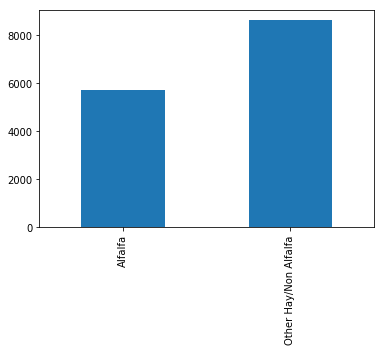

In [10]:
plt.figure()
df.plot.bar(legend=False)
plt.show()

## Objective 4: View a specific crop on the map.

Choose a crop from the above graph that has a high value. Use a color ramp that
highlights your chosen crop in red, and hides all other crops. Then search
for dense areas of your crop.

In [ ]:
target_crop = 'Barley'

crop_colormap = \
    gps.ColorMap.build(breaks={ crops_to_values[target_crop]: 0x00FF00FF },
                                classification_strategy=gps.ClassificationStrategy.EXACT,
                                fallback=0x00000000)    

tms_server = gps.TMS.build(pyramid, 
                           display=crop_colormap)
    
for l in M.layers:
    M.remove_layer(l)

M.add_layer(TMSRasterData(tms_server), name="cdl")

## Extra credit: View a specific crop on the map, using numpy to filter values.

Accomplish the same thing as Object 4. Instead of using a ColorMap to accomplish this, use map_tiles to map over the tiles of layer and set all values that don't match the crop value to tile.no_data_value. Then paint the resulting layer on the map.

In [ ]:
target_crop = 'Barley'

def mask_tile(tile):
    no_data_value = tile.no_data_value
    cells = tile.cells
    cells[cells != crops_to_values[target_crop]] = no_data_value
    return gps.Tile.from_numpy_array(cells, no_data_value=no_data_value)

crop_rdd = layer.map_tiles(mask_tile).repartition(100).cache()

In [ ]:
pyramid = crop_rdd.pyramid()

In [ ]:
for l in M.layers:
    M.remove_layer(l)
    
tms_server = gps.TMS.build(pyramid, 
                           display=cdl_colormap)
M.add_layer(TMSRasterData(tms_server), name="cdl")

## Reference: CDL values and crop names

Below is an expanded dictionary of values to CDL categories, 
as well as a list of crop names (with non-crop categories removed).

In [ ]:
values_to_crops = {0: 'Background',
                   1: 'Corn',
                   2: 'Cotton',
                   3: 'Rice',
                   4: 'Sorghum',
                   5: 'Soybeans',
                   6: 'Sunflower',
                   10: 'Peanuts',
                   11: 'Tobacco',
                   12: 'Sweet Corn',
                   13: 'Pop or Orn Corn',
                   14: 'Mint',
                   21: 'Barley',
                   22: 'Durum Wheat',
                   23: 'Spring Wheat',
                   24: 'Winter Wheat',
                   25: 'Other Small Grains',
                   26: 'Dbl Crop WinWht/Soybeans',
                   27: 'Rye',
                   28: 'Oats',
                   29: 'Millet',
                   30: 'Speltz',
                   31: 'Canola',
                   32: 'Flaxseed',
                   33: 'Safflower',
                   34: 'Rape Seed',
                   35: 'Mustard',
                   36: 'Alfalfa',
                   37: 'Other Hay/Non Alfalfa',
                   38: 'Camelina',
                   39: 'Buckwheat',
                   41: 'Sugarbeets',
                   42: 'Dry Beans',
                   43: 'Potatoes',
                   44: 'Other Crops',
                   45: 'Sugarcane',
                   46: 'Sweet Potatoes',
                   47: 'Misc Vegs & Fruits',
                   48: 'Watermelons',
                   49: 'Onions',
                   50: 'Cucumbers',
                   51: 'Chick Peas',
                   52: 'Lentils',
                   53: 'Peas',
                   54: 'Tomatoes',
                   55: 'Caneberries',
                   56: 'Hops',
                   57: 'Herbs',
                   58: 'Clover/Wildflowers',
                   59: 'Sod/Grass Seed',
                   60: 'Switchgrass',
                   61: 'Fallow/Idle Cropland',
                   63: 'Forest',
                   64: 'Shrubland',
                   65: 'Barren',
                   66: 'Cherries',
                   67: 'Peaches',
                   68: 'Apples',
                   69: 'Grapes',
                   70: 'Christmas Trees',
                   71: 'Other Tree Crops',
                   72: 'Citrus',
                   74: 'Pecans',
                   75: 'Almonds',
                   76: 'Walnuts',
                   77: 'Pears',
                   81: 'Clouds/No Data',
                   82: 'Developed',
                   83: 'Water',
                   87: 'Wetlands',
                   88: 'Nonag/Undefined',
                   92: 'Aquaculture',
                   111: 'Open Water',
                   112: 'Perennial Ice/Snow ',
                   121: 'Developed/Open Space',
                   122: 'Developed/Low Intensity',
                   123: 'Developed/Med Intensity',
                   124: 'Developed/High Intensity',
                   131: 'Barren',
                   141: 'Deciduous Forest',
                   142: 'Evergreen Forest',
                   143: 'Mixed Forest',
                   152: 'Shrubland',
                   176: 'Grassland/Pasture',
                   190: 'Woody Wetlands',
                   195: 'Herbaceous Wetlands',
                   204: 'Pistachios',
                   205: 'Triticale',
                   206: 'Carrots',
                   207: 'Asparagus',
                   208: 'Garlic',
                   209: 'Cantaloupes',
                   210: 'Prunes',
                   211: 'Olives',
                   212: 'Oranges',
                   213: 'Honeydew Melons',
                   214: 'Broccoli',
                   216: 'Peppers',
                   217: 'Pomegranates',
                   218: 'Nectarines',
                   219: 'Greens',
                   220: 'Plums',
                   221: 'Strawberries',
                   222: 'Squash',
                   223: 'Apricots',
                   224: 'Vetch',
                   225: 'Dbl Crop WinWht/Corn',
                   226: 'Dbl Crop Oats/Corn',
                   227: 'Lettuce',
                   229: 'Pumpkins',
                   230: 'Dbl Crop Lettuce/Durum Wht',
                   231: 'Dbl Crop Lettuce/Cantaloupe',
                   232: 'Dbl Crop Lettuce/Cotton',
                   233: 'Dbl Crop Lettuce/Barley',
                   234: 'Dbl Crop Durum Wht/Sorghum',
                   235: 'Dbl Crop Barley/Sorghum',
                   236: 'Dbl Crop WinWht/Sorghum',
                   237: 'Dbl Crop Barley/Corn',
                   238: 'Dbl Crop WinWht/Cotton',
                   239: 'Dbl Crop Soybeans/Cotton',
                   240: 'Dbl Crop Soybeans/Oats',
                   241: 'Dbl Crop Corn/Soybeans',
                   242: 'Blueberries',
                   243: 'Cabbage',
                   244: 'Cauliflower',
                   245: 'Celery',
                   246: 'Radishes',
                   247: 'Turnips',
                   248: 'Eggplants',
                   249: 'Gourds',
                   250: 'Cranberries',
                   254: 'Dbl Crop Barley/Soybeans'}

In [ ]:
crops = ['Corn',
         'Cotton',
         'Rice',
         'Sorghum',
         'Soybeans',
         'Sunflower',
         'Peanuts',
         'Tobacco',
         'Sweet Corn',
         'Pop or Orn Corn',
         'Mint',
         'Barley',
         'Durum Wheat',
         'Spring Wheat',
         'Winter Wheat',
         'Other Small Grains',
         'Rye',
         'Oats',
         'Millet',
         'Speltz',
         'Canola',
         'Flaxseed',
         'Safflower',
         'Rape Seed',
         'Mustard',
         'Alfalfa',
         'Other Hay/Non Alfalfa',
         'Camelina',
         'Buckwheat',
         'Sugarbeets',
         'Dry Beans',
         'Potatoes',
         'Other Crops',
         'Sugarcane',
         'Sweet Potatoes',
         'Misc Vegs & Fruits',
         'Watermelons',
         'Onions',
         'Cucumbers',
         'Chick Peas',
         'Lentils',
         'Peas',
         'Tomatoes',
         'Caneberries',
         'Hops',
         'Herbs',
         'Clover/Wildflowers',
         'Cherries',
         'Peaches',
         'Apples',
         'Grapes',
         'Pecans',
         'Almonds',
         'Walnuts',
         'Pears',
         'Pistachios',
         'Triticale',
         'Carrots',
         'Asparagus',
         'Garlic',
         'Cantaloupes',
         'Prunes',
         'Olives',
         'Oranges',
         'Honeydew Melons',
         'Broccoli',
         'Peppers',
         'Pomegranates',
         'Nectarines',
         'Greens',
         'Plums',
         'Strawberries',
         'Squash',
         'Apricots',
         'Vetch',
         'Lettuce',
         'Pumpkins',
         'Blueberries',
         'Cabbage',
         'Cauliflower',
         'Celery',
         'Radishes',
         'Turnips',
         'Eggplants',
         'Gourds',
         'Cranberries']